In [ ]:
!pip install --upgrade --user google-cloud-aiplatform langchain langchain-google-genai docarray langchain_core langchain_chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

# LCEL & Output Parsing
We will be talking deeper about the Langchain Expression Langchain with a brief reminder of what was covered previously in the basics.

For the Langchain Expression Language portion, we will talk about
- Pipe operator overload
- Runnables (RunnableSequence)
- RunnableParallel
- RunnableLambda
- RunnablePassthrough
- RAG Example
- Chained Generative Output

For the Output Parsing, I'll showcase Output Parsing which lets us control the output from the model
- JsonOutputParser
- StrOutputParser
- OutputFixingParser

In [ ]:
import os
from google.colab import userdata

if "GOOGLE_API_KEY" not in os.environ:
  os.environ['GOOGLE_API_KEY'] = userdata.get("GOOGLE_API_KEY")

In [ ]:
from langchain_google_genai import GoogleGenerativeAI
from google.colab import userdata

llm = GoogleGenerativeAI(
    model = "gemini-1.0-pro",
    temperate=1,
    location = "us-central1"
)

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = "Tell me a joke about {topic}"
prompt = ChatPromptTemplate.from_template(template)

template_2 = "Analyze the joke and say if it is a funny joke or not. {joke}"
second_prompt = ChatPromptTemplate.from_template(template_2)

In [ ]:
chain = prompt | llm | second_prompt | llm

In [ ]:
%%time
response = chain.invoke({"topic": "Cats"})

CPU times: user 43.9 ms, sys: 6.27 ms, total: 50.2 ms
Wall time: 2.79 s


In [ ]:
response

'This is a funny joke because it uses a pun to create a humorous twist. The punchline plays on the words "cat" and "catastrophe," creating a surprising and amusing connection between the two. The unexpected use of the word "cat-astrophes" adds a layer of cleverness to the joke, making it enjoyable and memorable.'

## Runnable Passthrough & Runnable Lambda & RunnableParallel

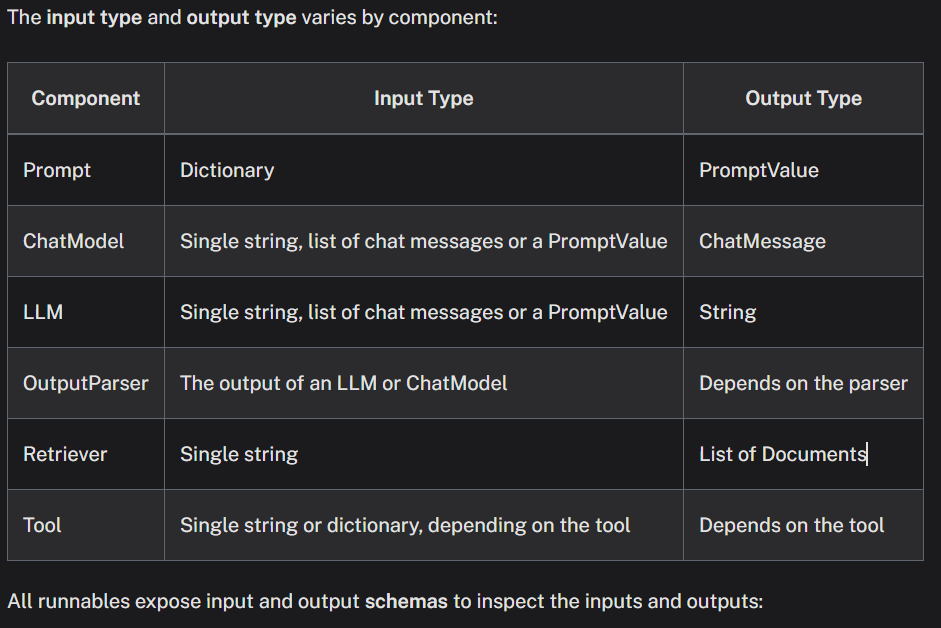

### Runnable Passthrough

In [ ]:
from langchain_core.runnables import RunnablePassthrough

In [ ]:
chain = RunnablePassthrough() | RunnablePassthrough() | RunnablePassthrough()
chain.invoke("Hello friends, this is Aaron")

'Hello friends, this is Aaron'

## Runnable Lambda

In [ ]:
def input_to_upper(input: str):
  output = input.upper()
  return output

In [ ]:
from langchain_core.runnables import RunnableLambda

chain = RunnablePassthrough() | RunnableLambda(input_to_upper) | RunnablePassthrough()
chain.invoke("Hello friends, this is Aaron")

'HELLO FRIENDS, THIS IS AARON'

## Runnable Parallel

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnableLambda

def double(input):
  # Recall that our INPUT is a dict
  number = input['input']
  return number*2 # <-- returns a NUMBER

def triple(input):
  number = input['input3']
  return number*3

chain = RunnableParallel(
    {
        "x": RunnablePassthrough() | RunnableLambda(double),
        "y": RunnablePassthrough(),
        "z": RunnablePassthrough() | RunnableLambda(triple)
    }
)

chain.invoke({"input": 10, "input2": 20, "input3": 15})

{'x': 20, 'y': {'input': 10, 'input2': 20, 'input3': 15}, 'z': 45}

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnableLambda
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embedder = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

def create_embedding(text: str):
  vector = embedder.embed_query(text)
  return vector[:5]


chain = RunnableParallel({"embed_text": RunnableLambda(create_embedding), "text": RunnablePassthrough()})

In [ ]:
chain.invoke("Hello, I'm Aaron!")

{'embed_text': [0.015839332714676857,
  -0.015412167645990849,
  -0.02236783131957054,
  -0.03603900969028473,
  0.0216364786028862],
 'text': "Hello, I'm Aaron!"}

## Example with ScaNN
[ScaNN Langchain Documentation](https://python.langchain.com/v0.2/docs/integrations/vectorstores/scann/)
[ScaNN Google Research](https://github.com/google-research/google-research/tree/master/scann)

Retrieval Demonstration with Google embeddings

In [ ]:
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
     

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import ScaNN
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = TextLoader("/content/google-history.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

embedder = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

db = ScaNN.from_documents(docs, embedder)
query = "How did Google Start?"
docs = db.similarity_search(query)

In [ ]:
docs

[Document(page_content="Google's search engine officially launched on September 4, 1998. The company's early success was fueled by its superior search algorithm, which provided more relevant and accurate search results compared to its competitors. Unlike other search engines of the time, Google focused on simplicity and user experience, featuring a clean, uncluttered homepage. This focus on delivering high-quality search results quickly earned Google a loyal user base.\n\nBy the early 2000s, Google had become the dominant search engine, surpassing established players like Yahoo! and AltaVista. In 2000, Google introduced AdWords, an online advertising service that allowed businesses to display ads based on keywords. AdWords revolutionized online advertising by making it accessible to businesses of all sizes and generating significant revenue for Google.\n\n#### Expanding Beyond Search", metadata={'source': '/content/google-history.txt'}),
 Document(page_content='### The Evolution and Im

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template=template)

retriever = db.as_retriever()

def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | ChatGoogleGenerativeAI(model="gemini-1.0-pro")
    | StrOutputParser()
)

In [ ]:
rag_chain.invoke("What is DeepMind?")

"DeepMind is a leading AI research lab that was acquired by Google in 2014. DeepMind's work focuses on developing AI systems capable of learning and problem-solving, and has had a significant impact on various industries."

### Demo Chained Generation

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableParallel, RunnableLambda

model = ChatGoogleGenerativeAI(model="gemini-1.0-pro")

title_template = """
  You are a youtube creator whose looking to create their next video. You're well-known for making tutorials

  First you need to setup a name for the marketing plan given the topic: {topic}
  Think about options then respond with a single title
"""
title_prompt = ChatPromptTemplate.from_template(title_template)

script_template = """
  Given the title for your next video: {title}
  Generate a short script for your youtube video where your content is funny but highly-informative
"""
script_prompt = ChatPromptTemplate.from_template(script_template)

description_template = """
  Given the brief manuscript:

  {script}

  Create the youtube description that has a witty paragraph of what it is about.
  Include potential timestamp highlights for your video.
"""
description_prompt = ChatPromptTemplate.from_template(description_template)


chain = title_prompt | model | script_prompt | model | description_prompt | model | StrOutputParser()

In [ ]:
chain.invoke("Mathematics")

"**Get Ready for the Math Adventure of a Lifetime!**\n\nJoin us on a hilarious and interactive journey through the world of numbers, shapes, and equations. This ultimate guide for beginners will transform math from a daunting subject into a wild and unforgettable experience.\n\n**Chapter Timestamps:**\n\n* 0:00 - Intro: Meet your math superheroes and prepare for the fun.\n* 0:50 - Chapter 1: The Basics of Math: Unlock the secret lair of numbers and operations.\n* 3:00 - Chapter 2: Algebra: Become a math detective and crack the code of equations.\n* 6:00 - Chapter 3: Geometry: Explore the hidden world of shapes and spaces.\n* 9:00 - Chapter 4: Trigonometry: Master the secrets of angles and triangles.\n* 12:00 - Chapter 5: Calculus: Unlock the ultimate superpower of math and understand how things change.\n* 15:00 - Outro: Celebrate your math mastery and embrace the joy of solving problems.\n\nSo, gather your math squad, prepare to laugh out loud, and let's make learning an unforgettable 

In [ ]:
chain.invoke("Literature")

"**YouTube video description:**\n\nPrepare yourself for a literary adventure like no other! Join us for the ultimate masterclass in literature, where we'll dissect books like a chef carves a turkey. Get ready to laugh, learn, and dive into the written word like never before.\n\n**Timestamp highlights:**\n\n* **0:00:** Introduction: Welcome to the literary rollercoaster!\n* **2:12:** Defining Literature: The literary candy store for your brain\n* **5:43:** Literary Devices: Metaphors and similes, the superheroes of writing\n* **8:27:** Character Analysis: Digging into the weird socks of literary stars\n* **12:03:** Theme Exploration: Uncovering the hidden messages in stories\n* **15:42:** The Power of Reading: Reading is the superpower you didn't know you had\n* **18:05:** Conclusion: Embrace the journey of reading and let the words ignite your imagination"